In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sb 
from PIL import Image 

from sklearn import metrics 

!pip install opencv-python
import cv2 
import os 

from glob import glob
!pip install tensorflow

import tensorflow as tf 
from tensorflow import keras 
from keras import layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

import warnings 
warnings.filterwarnings('ignore')


In [2]:
path = "D:/7092/train"
classes = os.listdir(path) 
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

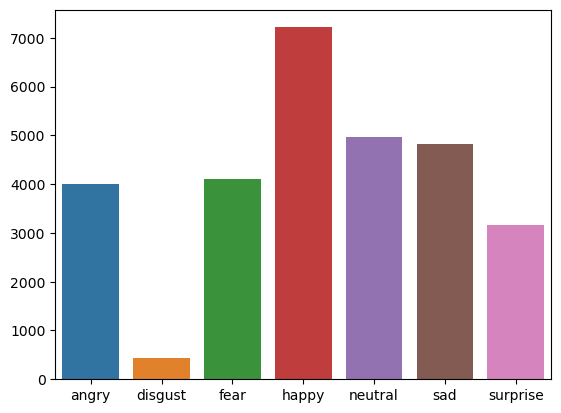

In [3]:
import seaborn as sb
import matplotlib.pyplot as plt
import os

path = "D:/7092/train"
classes = os.listdir(path)
count = []

for cat in classes: 
    count.append(len(os.listdir(f'{path}/{cat}')))

sb.barplot(x=classes, y=count) 
plt.show()


In [4]:
path = "D:/7092/test"
classes = os.listdir(path) 
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

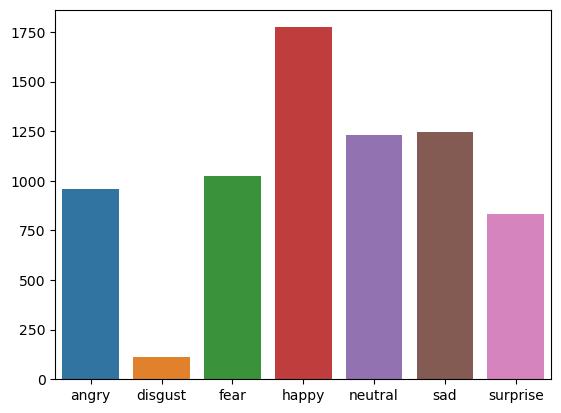

In [5]:
import seaborn as sb
import matplotlib.pyplot as plt
import os

path = "D:/7092/test"
classes = os.listdir(path)
count = []

for cat in classes: 
    count.append(len(os.listdir(f'{path}/{cat}')))

sb.barplot(x=classes, y=count) 
plt.show()


In [6]:
def convert_to_48x48_png(image_path):
    # Open image using PIL
    img = Image.open(image_path)
    
    # Check if image is already 48x48 and PNG
    if img.size == (48, 48) and img.format == 'PNG':
        print(f"Skipping {image_path} - Already 48x48 PNG")
        return
    
    # Convert to 48x48 grayscale PNG
    img = img.convert('L')  # Convert to grayscale if not already
    img = img.resize((48, 48))  # Resize to 48x48
    
    # Save as PNG
    new_path = os.path.splitext(image_path)[0] + '.png'
    img.save(new_path, format='PNG')
    
    print(f"Converted {image_path} to {new_path}")
    
    
directory = "D:/7092/train"

for filename in os.listdir(directory):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        image_path = os.path.join(directory, filename)
        convert_to_48x48_png(image_path)


In [7]:

train_datagen = ImageDataGenerator(rescale=1./255) 
val_datagen = ImageDataGenerator(rescale=1./255) 
  
train_gen = train_datagen.flow_from_directory( 
        "D:/7092/train", 
        target_size=(48,48), 
        batch_size=64, 
        color_mode="grayscale", 
        class_mode='categorical')

Found 28709 images belonging to 7 classes.


In [8]:
val_gen = val_datagen.flow_from_directory( 
        "D:/7092/test", 
        target_size=(48,48), 
        batch_size=64, 
        color_mode="grayscale", 
        class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [9]:
emotions = list(train_gen.class_indices.keys())


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([ 
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),									 
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2, 2), 
    layers.Flatten(), 
    layers.Dense(64, activation='relu'), 
    layers.BatchNormalization(),								 
    layers.Dense(32, activation='relu'), 
    layers.Dropout(0.3), 
    layers.BatchNormalization(), 
    layers.Dense(7, activation='softmax') 
])


In [11]:
model.compile( 
	optimizer = 'adam', 
	loss = 'categorical_crossentropy', 
	metrics=['accuracy'] 
)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if logs.get('val_accuracy') > 0.90: 
            print('\n Validation accuracy has reached upto 90% so, stopping further training.') 
            self.model.stop_training = True

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True) 
lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

In [13]:
history = model.fit(train_gen, 
					validation_data = val_gen, 
					epochs = 50, 
                    
					verbose = 1, 
					callbacks = [es, lr, myCallback()])


Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 249s 542ms/step - accuracy: 0.2653 - loss: 1.9594 - val_accuracy: 0.3456 - val_loss: 1.8691 - learning_rate: 0.0010
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 59s 131ms/step - accuracy: 0.4603 - loss: 1.4281 - val_accuracy: 0.3515 - val_loss: 1.7150 - learning_rate: 0.0010
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 62s 137ms/step - accuracy: 0.5166 - loss: 1.2923 - val_accuracy: 0.4262 - val_loss: 1.4988 - learning_rate: 0.0010
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 63s 140ms/step - accuracy: 0.5601 - loss: 1.1754 - val_accuracy: 0.4368 - val_loss: 1.4797 - learning_rate: 0.0010
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 62s 138ms/step - accuracy: 0.6011 - loss: 1.0740 - val_accuracy: 0.3631 - val_loss: 1.9210 - learning_rate: 0.0010
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6507 - loss: 0.9411
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
449/449 ━━━━━━━━━━━━━━━━━━━━ 62s 138ms/step - accuracy: 0.65

In [14]:
loss, accuracy = model.evaluate(val_gen, verbose=1)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Save the model
model.save('raffer_model.keras')

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5059 - loss: 1.6149
Validation Accuracy: 50.93%


In [15]:
def plot_image(img, emoj): 
	wmin = 200
	hmin = 200

	emoj = cv2.resize(emoj, (wmin, hmin)) 
	img = cv2.resize(img, (wmin, hmin)) 
	cv2.imshow('Images', cv2.hconcat([img, emoj]))

    


In [71]:
### Final code

In [51]:
import cv2
import numpy as np
from tkinter import Tk

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise IOError('Failed to load image file.')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

# Function to detect faces using Haar Cascade
def detect_faces(gray_img):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

# Placeholder for model and classes
# Assuming 'model' and 'classes' are already defined and loaded
# model = ... (load your model here)
# classes = ... (define your classes here)

# Function to preprocess face ROI for model prediction
def preprocess_face(face_roi):
    face_roi = cv2.resize(face_roi, (48, 48))
    face_roi = face_roi.astype('float32') / 255.0  # Normalize pixel values
    face_roi = np.expand_dims(face_roi, axis=-1)
    face_roi = np.expand_dims(face_roi, axis=0)
    return face_roi

# Function to predict emotion from face ROI
def predict_emotion(face_roi, model):
    pred = model.predict(face_roi)
    idx = pred.argmax(axis=-1)[0]
    return idx

# Function to load and resize emoji
def load_and_resize_emoji(emoji_path, w, h):
    emoj = cv2.imread(emoji_path)
    if emoj is not None:
        emoj = cv2.resize(emoj, (w, h))
    return emoj

# Function to overlay emoji on the face region
def overlay_emoji(img, emoj, x, y, w, h):
    if emoj is not None:
        img[y:y+h, x:x+w] = emoj
    else:
        print(f'Error: Emoji file not found. Skipping emoji overlay.')

# Function to resize images to fit within given dimensions
def resize_to_fit(img, max_width, max_height):
    height, width = img.shape[:2]
    scaling_factor = min(max_width / width, max_height / height)
    new_width = int(width * scaling_factor)
    new_height = int(height * scaling_factor)
    return cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

# Function to display images using cv2.imshow() in a single canvas
def plot_images_cv2(original_img, gray_img, emoj_img, class_name):
    # Resize images to fit within a grid cell
    max_width = 300
    max_height = 300
    original_img_resized = resize_to_fit(original_img, max_width, max_height)
    gray_img_resized = cv2.cvtColor(resize_to_fit(gray_img, max_width, max_height), cv2.COLOR_GRAY2BGR)
    
    if emoj_img is not None:
        emoj_img_resized = resize_to_fit(emoj_img, max_width, max_height)
    else:
        emoj_img_resized = np.zeros((max_height, max_width, 3), dtype=np.uint8)
    
    class_img = np.zeros((max_height, max_width, 3), dtype=np.uint8)
    cv2.putText(class_img, class_name, (10, max_height // 2), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Create a canvas to hold the 2x2 grid
    top_row = np.hstack((original_img_resized, gray_img_resized))
    bottom_row = np.hstack((emoj_img_resized, class_img))
    canvas = np.vstack((top_row, bottom_row))

    # Display the canvas
    cv2.imshow('Images', canvas)

# Main function to process the image and overlay emojis
def main(image_path):
    img, gray = load_and_preprocess_image(image_path)
    original_img = img.copy()  # Keep a copy of the original image
    faces = detect_faces(gray)

    if len(faces) == 0:
        print("No faces detected.")
        emoj = None
        class_name = 'No faces detected'
    else:
        for (x, y, w, h) in faces:
            x1, y1, x2, y2 = max(x, 0), max(y, 0), min(x + w, img.shape[1]), min(y + h, img.shape[0])
            face_roi = gray[y1:y2, x1:x2]
            face_roi = preprocess_face(face_roi)

            # Ensure 'model' and 'classes' are defined before this step
            idx = predict_emotion(face_roi, model)
            emoji_path = f'D:/7092/emojis/{classes[idx]}.jpg'
            emoj = load_and_resize_emoji(emoji_path, w, h)
            overlay_emoji(img, emoj, x, y, w, h)
            class_name = classes[idx]
            print({class_name})

    # Display the final result using cv2.imshow()
    plot_images_cv2(original_img, gray, emoj, class_name)

    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()

# Assuming 'model' and 'classes' are loaded here
# model = ... (load your model here)
# classes = ... (define your classes here)

# Run the main function
main("D:/7092/feartest.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
{'fear'}


In [66]:
### Output is only 2 images

In [64]:
import cv2
import numpy as np
from tkinter import Tk

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise IOError('Failed to load image file.')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

# Function to detect faces using Haar Cascade
def detect_faces(gray_img):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

# Placeholder for model and classes
# Assuming 'model' and 'classes' are already defined and loaded
# model = ... (load your model here)
# classes = ... (define your classes here)

# Function to preprocess face ROI for model prediction
def preprocess_face(face_roi):
    face_roi = cv2.resize(face_roi, (48, 48))
    face_roi = face_roi.astype('float32') / 255.0  # Normalize pixel values
    face_roi = np.expand_dims(face_roi, axis=-1)
    face_roi = np.expand_dims(face_roi, axis=0)
    return face_roi

# Function to predict emotion from face ROI
def predict_emotion(face_roi, model):
    pred = model.predict(face_roi)
    idx = pred.argmax(axis=-1)[0]
    return idx

# Function to load and resize emoji
def load_and_resize_emoji(emoji_path, w, h):
    emoj = cv2.imread(emoji_path)
    if emoj is not None:
        emoj = cv2.resize(emoj, (w, h))
    return emoj

# Function to overlay emoji on the face region
def overlay_emoji(img, emoj, x, y, w, h):
    if emoj is not None:
        img[y:y+h, x:x+w] = emoj
    else:
        print(f'Error: Emoji file not found. Skipping emoji overlay.')

# Function to display images using Tkinter for screen dimensions
def plot_image(img, emoj):
    root = Tk()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()

    wmin = screen_width // 2
    hmin = screen_height // 2

    def resize_to_fit(img, max_width, max_height):
        height, width = img.shape[:2]
        scaling_factor = min(max_width / width, max_height / height)
        new_width = int(width * scaling_factor)
        new_height = int(height * scaling_factor)
        return cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    emoj_resized = resize_to_fit(emoj, wmin, hmin)
    img_resized = resize_to_fit(img, wmin, hmin)

    combined_img = cv2.hconcat([img_resized, emoj_resized])
    cv2.imshow('Image', combined_img)

# Main function to process the image and overlay emojis
def main(image_path):
    img, gray = load_and_preprocess_image(image_path)
    faces = detect_faces(gray)

    if len(faces) == 0:
        print("No faces detected.")
    else:
        for (x, y, w, h) in faces:
            x1, y1, x2, y2 = max(x, 0), max(y, 0), min(x + w, img.shape[1]), min(y + h, img.shape[0])
            face_roi = gray[y1:y2, x1:x2]
            face_roi = preprocess_face(face_roi)

            # Ensure 'model' and 'classes' are defined before this step
            idx = predict_emotion(face_roi, model)
            emoji_path = f'C:/Users/majet_nb3xz3h/Desktop/project/emoji1/emojis/emojis1/{classes[idx]}.png'
            emoj = load_and_resize_emoji(emoji_path, w, h)
            overlay_emoji(img, emoj, x, y, w, h)
            print({classes[idx]})


    # Display the final result
    plot_image(img, emoj)
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()

# Run the main function
main("C:/Users/majet_nb3xz3h/Desktop/project/neutraltest.jpeg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
{'neutral'}
